In [1]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
buf = context.new_buffer()

# Ion properties:
m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
A = 207.98 # Lead-208
Z = 82  # Number of protons in the ion (Lead)
Ne = 3 # Number of remaining electrons (Lithium-like)
m_e = 0.511e6 # eV/c^2 -- electron mass
m_p = 938.272088e6 # eV/c^2 -- proton mass
c = 299792458.0 # m/s

m_ion = A*m_u + Ne*m_e # eV/c^2
equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

p0c = equiv_proton_momentum*(Z-Ne) # eV/c
gamma = np.sqrt( 1 + (p0c/m_ion)**2 ) # ion relativistic factor
beta = np.sqrt(1-1/(gamma*gamma)) # ion beta


In [2]:
#%%
##################
# Build TrackJob #
##################

fname_sequence ='/home/pkruyt/cernbox/xsuite-env/xtrack/test_data/sps_w_spacecharge/line_no_spacecharge_and_particle.json'

with open(fname_sequence, 'r') as fid:
     input_data = json.load(fid)
sequence = xt.Line.from_dict(input_data['line'])

n_part = int(1e4)

SPS_tracker = xt.Tracker(_context=context, _buffer=buf, line=sequence)

# Build a reference particle
particle_sample = xp.Particles(mass0=m_ion, q0=Z-Ne, p0c=p0c,_context=context)

sigma_z = 22.5e-2
nemitt_x = 2e-6
nemitt_y = 2.5e-6


particles = xp.generate_matched_gaussian_bunch(
         num_particles=n_part,
         #total_intensity_particles=bunch_intensity,
         nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=sigma_z,
         #R_matrix=r_matrix,
         particle_ref=particle_sample,
         tracker=SPS_tracker,
         #,steps_r_matrix=steps_r_matrix,
         )


sequence.particle_ref = particle_sample
twiss = sequence.twiss(symplectify=True)

twiss_dict=dict(twiss)

#%%
###################
# Linear Transfer #
###################

# arc=xt.LinearTransferMatrix(Q_x=twiss['qx'], Q_y=twiss['qy'],
# beta_x_0=twiss['betx'][0], beta_x_1=twiss['betx'][-1],
# beta_y_0=twiss['bety'][0], beta_y_1=twiss['bety'][-1],
# alpha_x_0=twiss['alfx'][0], alpha_x_1=twiss['alfx'][-1],
# alpha_y_0=twiss['alfy'][0], alpha_y_1=twiss['alfy'][-1],
# disp_x_0=twiss['dx'][0], disp_x_1=twiss['dx'][-1],
# disp_y_0=twiss['dy'][0], disp_y_1=twiss['dy'][-1],
# beta_s=twiss['betz0'],
# Q_s=-twiss['qs'],
# chroma_x=twiss['dqx'], chroma_y=twiss['dqy'])


qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=7000
beta_x=twiss['betx'][-1]
beta_y=twiss['bety'][-1]


# arc = xt.LineSegmentMap(
#         qx=qx, qy=qy,
#         dqx=dqx, dqy=dqy,
#         length=circumference,
#         betx=beta_x,
#         bety=beta_y
#         )

arc = xt.LinearTransferMatrix(
        Q_x=qx, Q_y=qy,        
        length=circumference,
        beta_x_0=twiss['betx'][0], beta_x_1=twiss['betx'][-1],
        beta_y_0=twiss['bety'][0], beta_y_1=twiss['bety'][-1],
        _context=context
        )


SPS_lin = xt.Line()

SPS_lin.append_element(arc,'SPS_LinearTransferMatrix') 

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The argument tracker is deprecated. Please use line instead. <class 'DeprecationWarning'>
*** Maximum RMS bunch length 0.23592919520901076m.
... distance to target bunch length: -2.2500e-01
... distance to target bunch length: 4.4112e-03
... distance to target bunch length: 4.1449e-03
... distance to target bunch length: -3.3479e-03
... distance to target bunch length: 1.0467e-03
... distance to target bunch length: 2.0728e-04
... distance to target bunch length: -3.3833e-06
... distance to target bunch length: 4.9353e-08
... distance to target bunch length: -6.5924e-08
--> Bunch length: 0.22500004935312237
--> Emittance: 0.6606168645424672


In [3]:
##################
# Laser Cooler #
##################

sigma_dp = 3e-4 # relative ion momentum spread
#sigma_dp = std_delta # relative ion momentum spread
sigma_dp=np.std(particles.delta.copy())
print('sigma_dp:',sigma_dp*1e3)

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
theta_l = 0
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
hw0 = 230.823 # eV
hc=constants.hbar*c/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# # Shift laser wavelength for fast longitudinal cooling:
lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = c/lambda_l # Hz

print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 2.5*1.3e-3


laser_x=0.0020000
laser_x=0.000000

gamma0=96

# I=2*100000000000

# laser_intensity=I/4/gamma0/gamma0

laser_intensity = 3.6e6 /4/gamma0/gamma0

laser_intensity=97
laser_intensity=97*10000*7

print('laser_intensity:',laser_intensity)

ion_excited_lifetime=76.6e-12

GF_IP = xt.CWLaser(_buffer=buf,
                      laser_x=laser_x,
                      laser_y=0,
                      laser_z=0,
                      
                      laser_direction_nx = 0,
                      laser_direction_ny = 0,
                      laser_direction_nz = -1,
                      laser_wavelength = lambda_l, # m
                      laser_waist_radius = laser_waist_radius, # m
                      laser_intensity=laser_intensity,
                      ion_excitation_energy = hw0, # eV
                      ion_excited_lifetime  = ion_excited_lifetime, # sec,
                          
   )
                          
   
SPS_lin.append_element(GF_IP, 'GammaFactory_IP')



##################
# Tracking #
##################
x, px, action_x,excited_list,delta_list= [], [], [], [], []
num_turns = int(1e0)
save_interval=num_turns/100

revolution_frequency = 43.387*1e6
s_per_turn = 1/revolution_frequency
time = np.arange(0, num_turns, save_interval) * s_per_turn

# # create a monitor object, to reduce holded data
# monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
#                               n_repetitions=int(num_turns/save_interval),
#                               repetition_period=save_interval,
#                               num_particles=n_part)

# line = xt.Line(
#         elements=[monitor, GF_IP, arc])



# line.particle_ref = xp.Particles(mass0=m_ion, q0=Z-Ne, p0c=p0c,_context=context)
# line.build_tracker()

# # just track all particles, and keep turn-by-turn data (memory expensive!)
# line.track(particles, num_turns=num_turns,
#               turn_by_turn_monitor=False)


# # extract relevant values
# x = monitor.x[:,:,0]
# px = monitor.px[:,:,0]
# y = monitor.y[:,:,0]
# py = monitor.py[:,:,0]
# delta = monitor.delta[:,:,0]
# time = monitor.at_turn[:, 0, 0] * s_per_turn

# loop over turns
for i in tqdm(range(num_turns)):
    if i % save_interval ==0:
    
        x.append(particles.x)
        px.append(particles.px)

        excited=particles.state==2
        fraction_excitation = sum(excited)/len(excited)

        excited_list.append(excited)

        delta_xs = particles.delta.copy()
        delta_list.append(delta_xs)
    
    # track particle
    arc.track(particles)
    GF_IP.track(particles)

excited=particles.state==2
fraction_excitation = sum(excited)/len(excited)


sigma_dp: 0.29548909846088534
Laser wavelength = 1034.17 nm
laser_intensity: 6790000


  0%|          | 0/1 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


07be88afdf4c45e89bad62cd94fc9926.c: In function ‘CWLaser_track_local_particle’:
07be88afdf4c45e89bad62cd94fc9926.c:3522:9: warning: multi-line comment [-Wcomment]
         // double OmegaRabi = \
         ^
07be88afdf4c45e89bad62cd94fc9926.c:3531:16: warning: unused variable ‘OmegaRabiTau’ [-Wunused-variable]
         double OmegaRabiTau = OmegaRabi/(2.0*gamma); // in the ion rest frame
                ^~~~~~~~~~~~
07be88afdf4c45e89bad62cd94fc9926.c:3456:12: warning: unused variable ‘beta0’ [-Wunused-variable]
     double beta0  = sqrt(1.0 - 1.0/(gamma0*gamma0));
            ^~~~~
100%|██████████| 1/1 [00:05<00:00,  5.09s/it]

Done compiling ContextCpu kernels.


In [4]:
np.savez('results/delta_data.npz',delta=delta_list,excited=excited_list,time=time,x=x)



In [5]:
print(fraction_excitation)

0.0217


<Figure size 640x480 with 0 Axes>

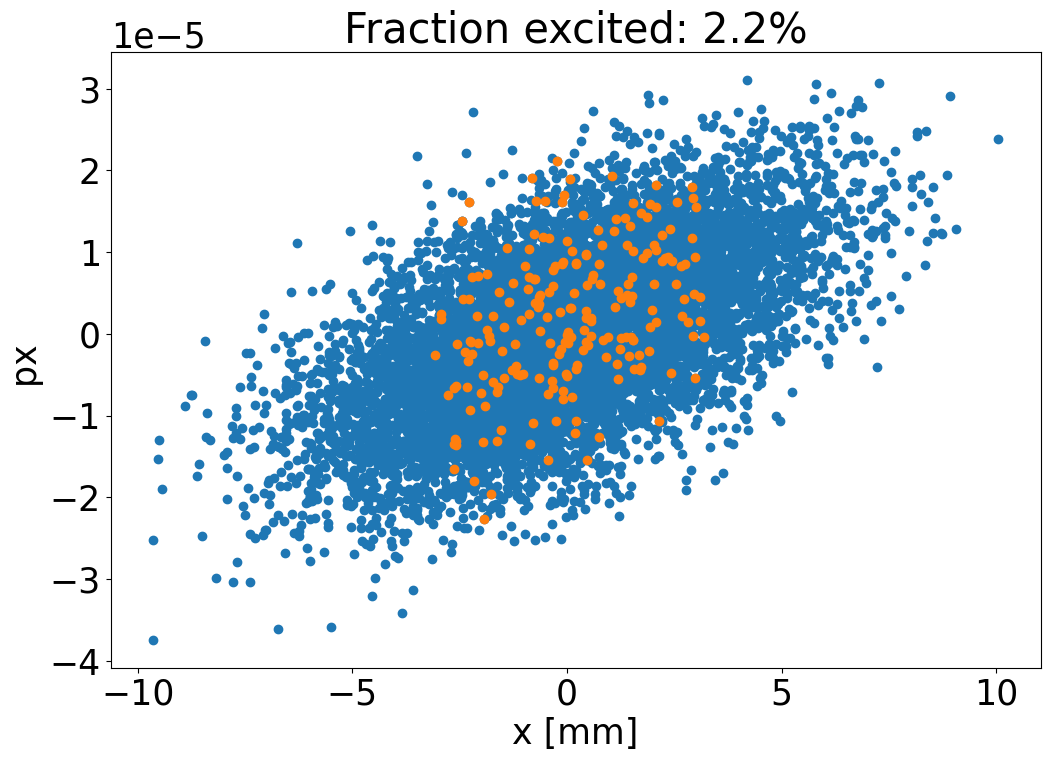

In [6]:
plt.figure()
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction excited: {round(fraction_excitation*100, 1)}%')
#plt.axvline(laser_x,color='red')
# plt.axvline(laser_x+laser_waist_radius,color='red')
# plt.axvline(laser_x-laser_waist_radius,color='red')

plt.scatter(particles.x*1e3,particles.px)
plt.scatter(particles.x[excited]*1e3,particles.px[excited])
plt.xlabel('x [mm]')
plt.ylabel('px ')
plt.show()

<Figure size 640x480 with 0 Axes>

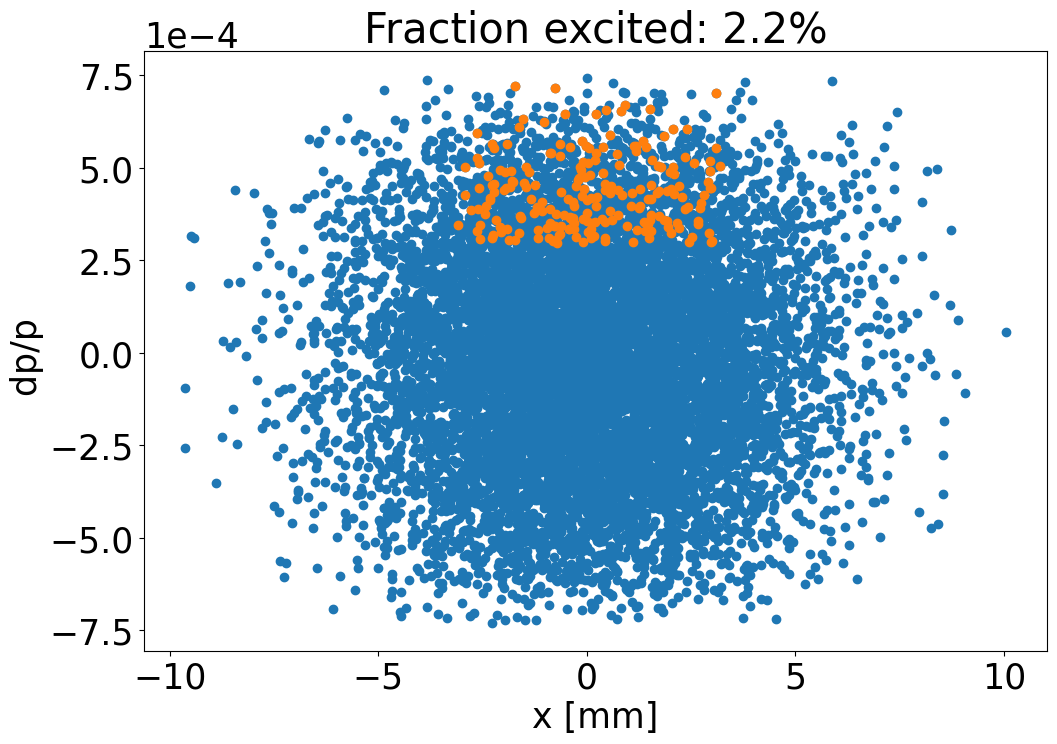

In [7]:
plt.figure()
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction excited: {round(fraction_excitation*100, 1)}%')

#plt.axvline(laser_x,color='red')
# plt.axvline(laser_x+laser_waist_radius,color='red')
# plt.axvline(laser_x-laser_waist_radius,color='red')

plt.scatter(particles.x*1e3,particles.delta)
plt.scatter(particles.x[excited]*1e3,particles.delta[excited])
plt.xlabel('x [mm]')
plt.ylabel('dp/p ')
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('First_turn.eps', format='eps', dpi=300)
plt.show()